In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
import seaborn as sn #for heatmaps
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#load cifar 10 dataset
transform = transforms.ToTensor()

In [4]:
#load to train data
train_data = datasets.CIFAR10(root='C:/Users/A221LPEN/Desktop/Pytorch_for_Deep_Learning/PYTORCH_NOTEBOOKS/myCodes/Data', train=True, download=True, transform=transform)

Files already downloaded and verified


In [5]:
test_data = datasets.CIFAR10(root='C:/Users/A221LPEN/Desktop/Pytorch_for_Deep_Learning/PYTORCH_NOTEBOOKS/myCodes/Data', train=False, download=True, transform=transform)

Files already downloaded and verified


In [6]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Split: train
    Root Location: C:/Users/A221LPEN/Desktop/Pytorch_for_Deep_Learning/PYTORCH_NOTEBOOKS/myCodes/Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [7]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Split: test
    Root Location: C:/Users/A221LPEN/Desktop/Pytorch_for_Deep_Learning/PYTORCH_NOTEBOOKS/myCodes/Data
    Transforms (if any): ToTensor()
    Target Transforms (if any): None

In [8]:
torch.manual_seed(101)
train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10,shuffle=False)

In [9]:
class_names = ['plane',' car',' bird',' cat',' deer',' dog',' frog',' horse',' ship',' truck']

In [10]:
#grab 1st batch images
for images,labels in train_loader:
    break

In [11]:
labels #3-bird,2-car,0-plane...

tensor([3, 2, 0, 4, 9, 5, 1, 2, 4, 8])

Label: [3 2 0 4 9 5 1 2 4 8]
Class:  cat  bird plane  deer  truck  dog  car  bird  deer  ship


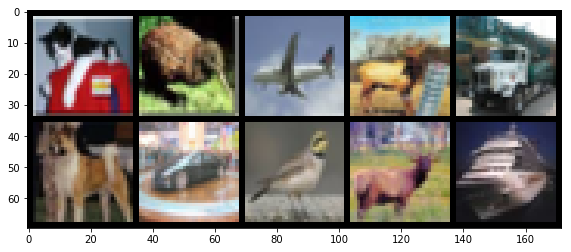

In [12]:
#print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))



im = make_grid(images,nrow=5)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [13]:
#pretty blurry as these are 32x32 pixels
#if we run these images in ANN,we can flatten them but its not going to be able to predict

In [17]:
#PART 2 -- CREATE MODEL & TRAIN
class ConvolutionalNetwork(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3,6,5,1) # 3-RGB/colour image, 6 filters--randomly chosen,5--5x5 kernel,1--stride default
        self.conv2 = nn.Conv2d(6,16,3,1) #6-inherit conv2 filter, 16-arbitrary/random,3-3x3 image kernel(normal to reduce),1-stride
        self.fc1 = nn.Linear(6*6*16,120) # (((32-2)/2)-2)/2 = 6.5--> rounded to 6
        self.fc2 = nn.Linear(120,84) #120-match with fc1, 84-arbitrary
        self.fc3 = nn.Linear(84,10) #84 inherit from fc2, 10-total num of classes
        
        
    def forward(self,X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X,2,2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X,2,2)
        X = X.view(-1,6*6*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X,dim=1)
        

In [18]:
#create CNN
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [19]:
#check parameters
for param in model.parameters():
    print(param.numel()) #numel--number of element

450
6
864
16
69120
120
10080
84
840
10


In [20]:
#total 81302 parameters

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [22]:
#train the model---exact same as MNIST
import time
start_time = time.time()

#VARIABLES (TRACKERS)
epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []


#FOR LOOP EPOCHS
for i in range(epochs):
    
    trn_corr = 0
    tst_corr = 0
    
    #RUN THE TRAINING BATCHES
    for b,(X_train,y_train) in enumerate(train_loader):
        b +=1
        
        #APPLY THE MODEL
        y_pred = model(X_train) #no need to flatted--> we are feeding 2D data coz CNN expects 2d data
        loss = criterion(y_pred,y_train)
        
        #TALLY THE NUMBER OF CORRECT PREDICTIONS
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum() #True 1 /False 0 sum()
        trn_corr += batch_corr
        
        #update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        #PRINT INTERIM RESULTS
        if b%1000 ==0:
            print(f'Epoch: {i:2} Batch: {b:4} [{10*b:6}/50000] Loss: {loss.item():10.8f} accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
            
            
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
        
    
    #RUN THE TESTING BATCHES
    with torch.no_grad():
        for b,(X_test,y_test) in enumerate(test_loader):
            
            y_val = model(X_test)
            
            predicted = torch.max(y_val.data,1)[1]
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val,y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)

print(f"\nDuration: {time.time() - start_time: .0f} seconds")

Epoch:  0 Batch: 1000 [ 10000/50000] Loss: 1.67355442 accuracy:  26.710%
Epoch:  0 Batch: 2000 [ 20000/50000] Loss: 1.45116973 accuracy:  32.230%
Epoch:  0 Batch: 3000 [ 30000/50000] Loss: 1.87373388 accuracy:  35.730%
Epoch:  0 Batch: 4000 [ 40000/50000] Loss: 1.68802071 accuracy:  38.182%
Epoch:  0 Batch: 5000 [ 50000/50000] Loss: 2.21869493 accuracy:  39.974%
Epoch:  1 Batch: 1000 [ 10000/50000] Loss: 1.20014679 accuracy:  48.960%
Epoch:  1 Batch: 2000 [ 20000/50000] Loss: 1.56332612 accuracy:  49.580%
Epoch:  1 Batch: 3000 [ 30000/50000] Loss: 0.76813745 accuracy:  49.997%
Epoch:  1 Batch: 4000 [ 40000/50000] Loss: 1.09740090 accuracy:  50.542%
Epoch:  1 Batch: 5000 [ 50000/50000] Loss: 1.69403386 accuracy:  51.040%
Epoch:  2 Batch: 1000 [ 10000/50000] Loss: 0.92882699 accuracy:  54.860%
Epoch:  2 Batch: 2000 [ 20000/50000] Loss: 1.12537169 accuracy:  55.080%
Epoch:  2 Batch: 3000 [ 30000/50000] Loss: 1.60666084 accuracy:  55.547%
Epoch:  2 Batch: 4000 [ 40000/50000] Loss: 1.133344

In [23]:
#SAVE MODEL
torch.save(model.state_dict(),'myCIFARmodel.pt')

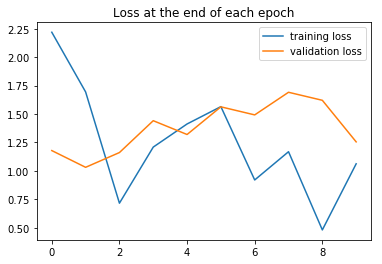

In [25]:
plt.plot(train_losses,label='training loss')
plt.plot(test_losses,label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()

In [26]:
#maybe need to train through a couple more epoch to get it flattened (clear trend)

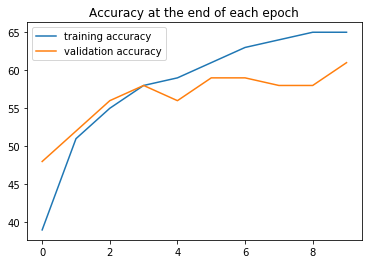

In [27]:
#ACCURACY
plt.plot([t/500 for t in train_correct],label='training accuracy')
plt.plot([t/100 for t in test_correct],label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

In [28]:
print(test_correct)

[tensor(4847), tensor(5260), tensor(5651), tensor(5862), tensor(5655), tensor(5905), tensor(5935), tensor(5870), tensor(5869), tensor(6118)]


In [29]:
num_c = test_correct[-1].item()

In [30]:
num_c *100 /10000

61.18

In [31]:
#This is not as impressive as with MNIST, which makes sense. We would have to adjust our parameters to obtain better results.
#Still, it's much better than the 10% we'd get with random chance!

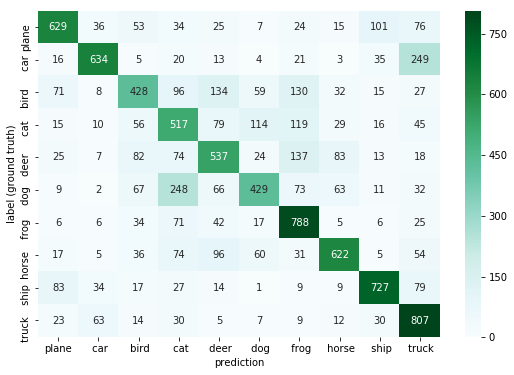

In [32]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sn.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

In [ ]:
#diagonal become darker = what we want
#truck is often being misclasses as car